## Este ejemplo muestra como usar el metodo pvlib.location.Location.get_clearsky() para generar datos de la Global Horizontal Irradiance utilizando metodos de clielo_despejado (clearsly) y también como usar la función pvlib.irradiance.get_total_irradiance() para transponer los datos de la GHI a la irradiencia en el plano del arreglo (POA)

In [1]:
from pvlib import location
from pvlib import irradiance
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#Cutonalá
tz = 'America/Mexico_City'
lat, lon = 20.5, -103.2

In [3]:
#crear un objeto con la instancia Location, para guardar los datos del sitio (CUTONALÁ)
site = location.Location(lat, lon, tz=tz)

In [4]:
#Calcular de cielo despejado la GHI y transponer a irradiancia en el plano del arreglo (POA)
#Se define una función, de esa manera podemos reutilizar la secuencia de las operaciones con diferentes sitios
def get_irradiance(site_location, date, tilt, surface_azimmuth):
    #Se crean intervalos de 10 minutos para un día
    times = pd.date_range(date, freq='10min', periods=6*24, tz=site_location.tz)
    #generar datos utilizando cielo despejado con el modelo de Ineichen, el cual viene por default en pvlib
    #el metodo get_clearsky retorna un dataframe con los valores de GHI, DNI y DHI
    clearsky = site_location.get_clearsky(times)
    #Se debe obtener el azimut y el zenit solar para pasarlo a la función de trasposición
    solar_position = site_location.get_solarposition(times=times)
    #usamos la función get_total_irradiance para transponer de GHI a POA
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimmuth,
        dni = clearsky['dni'],
        ghi = clearsky['ghi'],
        dhi = clearsky['dhi'],
        solar_zenith = solar_position['apparent_zenith'],
        solar_azimuth = solar_position['azimuth']
    )
    #regresa el datafraem con solo el GHI y el POA
    return pd.DataFrame({'GHI': clearsky['ghi'], 'POA': POA_irradiance['poa_global']})

In [5]:
#Hacemos simulación, obtenemos la irradiancia de los solcticios de verano e invierno, asumiendo 25 grados de tilt (inclinación)
#y el arreglo hacia el sur
summer_irradiance = get_irradiance(site, '06-20-2020', 25, 180)
winter_irradiance = get_irradiance(site, '12-21-2020', 25, 180)

#Convertimos los indices del DataFrame a formato de hora para hacer más facil el graficado
summer_irradiance.index = summer_irradiance.index.strftime("%H:%M")
winter_irradiance.index = winter_irradiance.index.strftime("%H:%M")

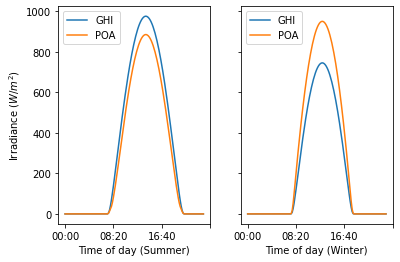

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
summer_irradiance['GHI'].plot(ax=ax1, label='GHI')
summer_irradiance['POA'].plot(ax=ax1, label='POA')
winter_irradiance['GHI'].plot(ax=ax2, label='GHI')
winter_irradiance['POA'].plot(ax=ax2, label='POA')
ax1.set_xlabel('Time of day (Summer)')
ax2.set_xlabel('Time of day (Winter)')
ax1.set_ylabel('Irradiance ($W/m^2$)')
ax1.legend()
ax2.legend()
plt.show()